<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# A ver si salimos de pobres<a id="top"></a>

<i><small>Autor: Alberto Díaz Álvarez<br>Última actualización: 2023-03-14</small></i></div>
                                                  

***

## Introducción

Vamos a explorar el comportamiento de una red recurrente en un problema muy difícil como lo es la predicción de valores bursátiles. Cuando lleguemos a NLP veremos ejemplos que demostrarán las capacidades de las redes neuronales recurrentes en problemas donde el contexto temporal sí es determinante para el resultado final.

## Objetivos

Crearemos un modelo de regresión para intentar predecir el valor de cierre que tomarán las acciones de [Google](https://www.nasdaq.com/market-activity/stocks/goog/historical) en 10 días a partir de la fecha actual

Al finalizar habremos aprendido a:

- Convertir series temporales a un formato apto para alimentar redes neuronales recurrentes
- Identificar un error típico a la hora de realizar predicciones
- Crear, entrenar y comprobar el desempeño de redes neuronales recurrentes para problemas de naturaleza secuencial

## Imports y configuración

A continuación importaremos las librerías que se usarán a lo largo del notebook. Entre las que ya hemos visto durante el curso, importamos además:

- `sklearn.preprocessing MinMaxScaler` para normalizar automáticamente los valores de una serie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

Asímismo, configuramos algunos parámetros para adecuar la presentación gráfica.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Descarga y preprocesamiento de datos

Comenzaremos cargando los datos del dataset de los valores de Google. Ya los tenemos descargados en el _path_ relativo `Datasets/GOOG-full-historical-data-20211004.csv`. En este caso el dataset tiene las cabeceras en inglés. Por lo demás, es exactamente igual al del primer ejemplo que vimos

In [4]:
df = pd.read_csv('Datasets/GOOG-20211004.csv', index_col='Date', parse_dates=['Date'])
df = df.replace('[\$]', '', regex=True).astype('float')
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2021-10-01,2729.25,1419365.0,2671.090,2741.42,2667.55
2021-09-30,2665.31,1768199.0,2686.500,2711.80,2660.00
2021-09-29,2690.42,1316861.0,2742.194,2747.97,2685.00
2021-09-28,2723.68,2109483.0,2781.770,2792.13,2714.00
2021-09-27,2830.02,942204.0,2831.710,2850.00,2810.00


El dataset que hemos descargado mantiene la información del día. Nuestro objetivo será predecir el valor de cierre del día a partir de los datos de la semana pasada, para saber qué tipo de inversión nos conviene.

A la red la alimentaremos con los datos de hace 10 días anteriores a ver si la memoria sobre cómo evolucionan los valores se traduce en una mejor predicción. Para ello, comenzaremos creando $9 \cdot 5$ columnas nuevas con los contenidos de las columnas en cada timestep consecutivo.

Ojo, primero hay que ordenar ascendentemente el conjunto para asegurarnos de que tenemos los días correctamente colocados. Segundo, las primeras 

In [5]:
SEQUENCE_LEN = 10

df.sort_index(inplace=True)
columns = df.columns
for i in range(1, SEQUENCE_LEN):
    for column in columns:
        df[f'{column} t-{i}'] = df[column].shift(i)
df.drop(df.head(SEQUENCE_LEN - 1).index, inplace=True)
df

,Close/Last,Volume,Open,High,Low,Close/Last t-1,Volume t-1,Open t-1,High t-1,Low t-1,...,Close/Last t-8,Volume t-8,Open t-8,High t-8,Low t-8,Close/Last t-9,Volume t-9,Open t-9,High t-9,Low t-9
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-09,564.14,3321485.0,559.620,565.37,552.9500,554.90,3141406.0,542.600,555.00,541.610,...,559.99,41003.0,561.200,566.4300,558.6700,558.46,13052.0,568.000,568.00,552.9200
2014-04-10,540.95,4025527.0,565.000,565.00,539.9000,564.14,3321485.0,559.620,565.37,552.950,...,556.97,10772.0,566.890,567.0000,556.9300,559.99,41003.0,561.200,566.43,558.6700
2014-04-11,530.60,3913747.0,532.550,540.00,526.5300,540.95,4025527.0,565.000,565.00,539.900,...,567.16,7932.0,558.710,568.4500,558.7100,556.97,10772.0,566.890,567.00,556.9300
2014-04-14,532.52,2561317.0,538.250,544.10,529.5610,530.60,3913747.0,532.550,540.00,526.530,...,567.00,146697.0,599.990,604.8300,562.1900,567.16,7932.0,558.710,568.45,558.7100
2014-04-15,536.44,3840157.0,536.820,538.45,518.4601,532.52,2561317.0,538.250,544.10,529.561,...,569.74,5080231.0,569.850,587.2800,564.1300,567.00,146697.0,599.990,604.83,562.1900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,2830.02,942204.0,2831.710,2850.00,2810.0000,2852.66,747467.0,2818.920,2858.07,2817.010,...,2904.12,1032671.0,2875.180,2911.6300,2845.1200,2868.12,945957.0,2883.220,2894.55,2858.1100
2021-09-28,2723.68,2109483.0,2781.770,2792.13,2714.0000,2830.02,942204.0,2831.710,2850.00,2810.000,...,2887.47,1014942.0,2902.420,2904.0000,2868.3272,2904.12,1032671.0,2875.180,2911.63,2845.1200
2021-09-29,2690.42,1316861.0,2742.194,2747.97,2685.0000,2723.68,2109483.0,2781.770,2792.13,2714.000,...,2829.27,3001991.0,2875.970,2884.9900,2821.2300,2887.47,1014942.0,2902.420,2904.00,2868.3272


Seguiremos creando una nueva columna denominada `Y` con los valores de la columna `Close/Last` de una semana después. Similar a antes, las últimas 7 filas del dataset no nos servirán de nada puesto que no podemos ver el futuro, así que las eliminaremos.

In [6]:
DAYS_IN_FUTURE = 7

df['Y'] = df['Close/Last'].shift(-DAYS_IN_FUTURE)
df.drop(df.tail(DAYS_IN_FUTURE).index, inplace=True)

df[[
    c for c in df.columns
    if c.startswith('Close') or c == 'Y'
]].tail(DAYS_IN_FUTURE + 1)

,Close/Last,Close/Last t-1,Close/Last t-2,Close/Last t-3,Close/Last t-4,Close/Last t-5,Close/Last t-6,Close/Last t-7,Close/Last t-8,Close/Last t-9,Y
Date,,,,,,,,,,,
2021-09-13,2869.30,2838.42,2898.27,2897.67,2910.38,2895.50,2884.38,2916.84,2909.24,2909.39,2818.77
2021-09-14,2868.12,2869.30,2838.42,2898.27,2897.67,2910.38,2895.50,2884.38,2916.84,2909.24,2836.53
2021-09-15,2904.12,2868.12,2869.30,2838.42,2898.27,2897.67,2910.38,2895.50,2884.38,2916.84,2852.66
2021-09-16,2887.47,2904.12,2868.12,2869.30,2838.42,2898.27,2897.67,2910.38,2895.50,2884.38,2830.02
2021-09-17,2829.27,2887.47,2904.12,2868.12,2869.30,2838.42,2898.27,2897.67,2910.38,2895.50,2723.68
2021-09-20,2780.34,2829.27,2887.47,2904.12,2868.12,2869.30,2838.42,2898.27,2897.67,2910.38,2690.42
2021-09-21,2792.93,2780.34,2829.27,2887.47,2904.12,2868.12,2869.30,2838.42,2898.27,2897.67,2665.31
2021-09-22,2818.77,2792.93,2780.34,2829.27,2887.47,2904.12,2868.12,2869.30,2838.42,2898.27,2729.25


Ahora normalizaremos los valores entre 0 y 1 para que el impacto de las entradas sea similar y no haya ninguna que destaque. Para ello haremos uso de la clase `MinMaxScaler`, que además de normalizar, mantiene el estado para poder usarla también como mecanismo de desnormalización.

Lo malo es que `MinMaxScaler` nos convertirá nuestro `DataFrame` en un array bidimensional, así que perderemos la información del índice y las columnas. Lo bueno es que está ordenado y sabemos su orden, así que si no tenemos que tratar los datos nos lo podemos permitir.

In [7]:
input_scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler.fit(df.iloc[:,:-1])
output_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler.fit(df.iloc[:,-1:]);

Vamos a extraer un conjunto de test para probar lo bien que se comporta nuestro modelo. Este estará compuesto de los últimos 100 días del _dataset_. Estos datos estarán normalizados entre 0 y 1 con los normalizadores que hemos creado, y ya que estamos aprovecharemos y generaremos los datos de entrada y salida. Ojo, no hace falta normalizar los datos de salida del conjunto de test, ya que en ningún momento los vamos a usar en nuestro modelo, sólo los usaremos para comparar.

Un apunte; Para las redes recurrentes la entrada se espera que sea tridimensional, pero nuestro conjunto de datos es bidimensional. Tenemos que transformarla en tridimensional, manteniendo la última dimensión de tamaño 1.

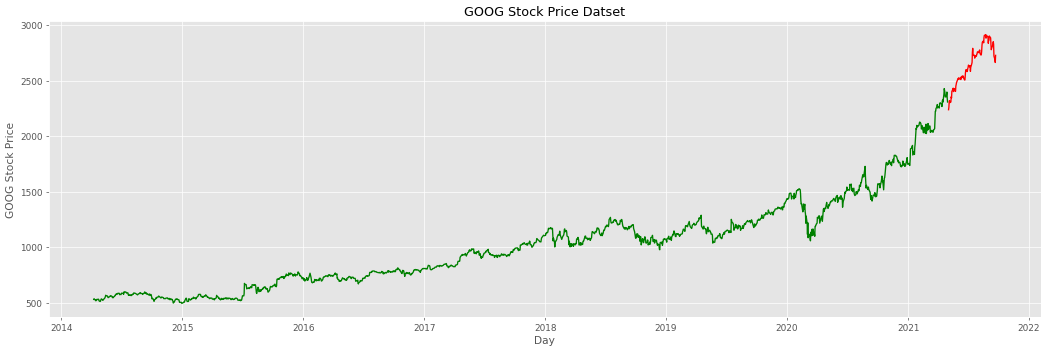

Dataset shape:      (1878, 51)
Training: X shape = (1778, 10, 5); Y shape = (1778, 1)
Test:     X shape = (100, 10, 5); Y shape = (100, 1)


In [8]:
TEST_SIZE = 100

train_df, test_df = df.iloc[:-TEST_SIZE,:], df.iloc[-TEST_SIZE:,:]

X_train, Y_train = train_df.iloc[:,:-1], train_df.iloc[:,-1:]
X_test, Y_test = test_df.iloc[:,:-1], test_df.iloc[:,-1:]

plt.plot(Y_train, color='green', label='Train')
plt.plot(Y_test, color='red', label='Test')
plt.title('GOOG Stock Price Datset')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.show()

X_train = input_scaler.transform(X_train)
X_test = input_scaler.transform(X_test)
Y_train = output_scaler.transform(Y_train)

X_train = np.reshape(X_train, (
    X_train.shape[0],                 # Examples
    SEQUENCE_LEN,                     # Number of timesteps
    X_train.shape[1] // SEQUENCE_LEN  # Number of components each sequence element
))
X_test = np.reshape(X_test, (X_test.shape[0], SEQUENCE_LEN, X_test.shape[1] // SEQUENCE_LEN))

print(f'Dataset shape:      {df.shape}')
print(f'Training: X shape = {X_train.shape}; Y shape = {Y_train.shape}')
print(f'Test:     X shape = {X_test.shape}; Y shape = {Y_test.shape}')

## Implementando y entrenando nuestro modelo

Crearemos un modelo recurrente que, a partir de los datos de entrada (los datos bursátiles de un día determinado) sea capaz de inferir el valor de cierre del valor siete días después.

Para ello, usaremos una unidad neuronal recurrente simple `SimpleRNN`.

Concretamente la red que crearemos estará compuesta de dos capas de unidades recurrentes de 128 parámetros con una capa dropout tras cada una de ellas, de esta forma:

`Input`->`SimpleRNN`->`Dropout`->`SimpleRnn`->`Dropout`->`Output`

Usaremos un optimizador de descenso estocástico del gradiente y como función de pérdida el error cuadrático medio

Recordemos que cuando las unidades recurrentes se apilan unas sobre otras hay que usar el parámetro `return_sequences` para que se conecten con toda la secuencia, si no dará error.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 128)           17152     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 50,177
Trainable params: 50,177
Non-trainable params: 0
_________________________________________________________________


Ahora pasaremos a entrenar el modelo a ver qué tal se comporta. Lo entrenaremos durante 100 epochs para ver qué tal se comporta

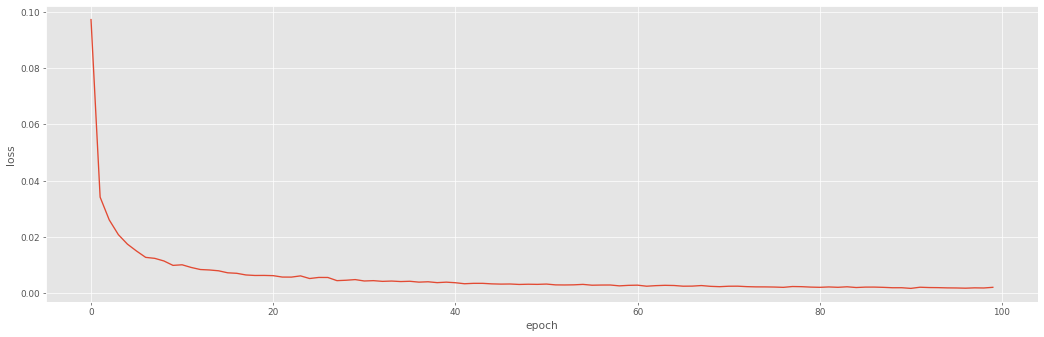

In [10]:
history = model.fit(X_train, Y_train, epochs=100, verbose=0)

plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

No sólo no ha ido mal, sino que ¡ha ido estupendo! Lo mismo sí nos hacemos ricos después de todo...

## Prediciendo los valores

Por último predeciremos para el conjunto de test los valores de las acciones para posteriormente compararlos con los valores de verdad.

Una nota: los datos de test están con un índice de fecha (es una `Serie` de pandas) mientras que la predicción vienen como array de `NumPy`. Habrá que conseguier que ambos índices se correspondan

4/4 [==============================] - 0s 2ms/step


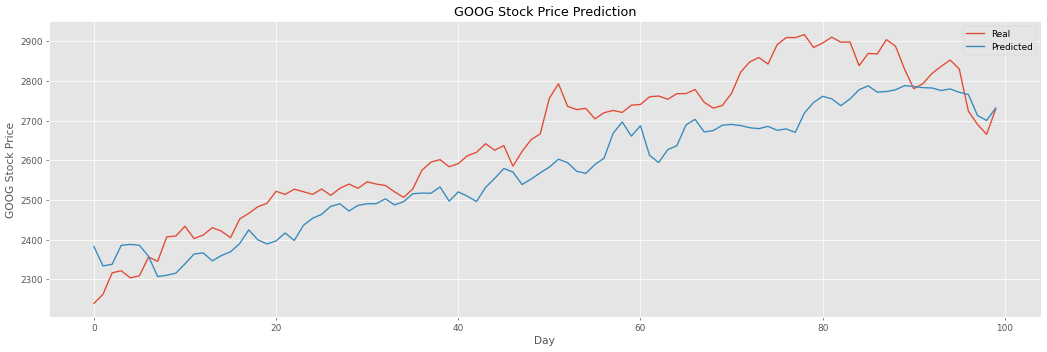

In [11]:
predicted = model.predict(X_test)
predicted = output_scaler.inverse_transform(predicted)
Y_test_as_array = Y_test.to_numpy()

plt.plot(Y_test_as_array, label = 'Real')
plt.plot(predicted, label = 'Predicted')
plt.title('GOOG Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('GOOG Stock Price')
plt.legend()
plt.show()

A la vista de los resultados, algo raro parece que está pasando... ¿Nos vamos a hacer ricos o no? ¿Se os ocurre alguna explicación a esta predicción tan curiosa? ¿alguien se anima con alguna alternativa?

## Conclusiones

Hemos visto cómo implementar redes neuronales recurrents en un problema puro de series temporales. También hemos visto que no se comporta demasiado bien, pero no tiene por qué ser así (en este caso hay truco).

Las series temporales mantienen correlación entre elementos consecutivos, y esas relaciones son las que las redes aprenden. Cuanto mayor es la correlación (absoluta) entre elementos, más probable es que la adivine la red. Sin embargo, sucesiones de elementos con valor aleatorio (que no tienen nada que ver unos con los siguientes) no son problemas que se puedan resolver con este tipo de redes. Ni siquiera son series temporales por definición.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>